In [1]:
import pandas as pd
from pprint import pprint as p
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import joypy
from matplotlib import cm
import warnings
warnings.simplefilter("ignore")

# import the dataset
deathdf = pd.read_csv("sample5death05_15.csv", low_memory=False)


# TODO
#   low - Comment block sections
#   low - Add fig.x text on each graphic
#   high - Get sources for data
#   high - test variance between full dataset and sample
#   med - Graph Aesthetics
#   med - Save PNGs
#   low - dummies demo
#   med - start markdown
#   high - define questions

# functions to create helper columns
#  TODO    Maybe replace the functions returning 1 with dummies
#           Or leave them in to demonstrate two ways of accomplishing task
def suiYN(x):
    if x in (124, 125, 126):
        return "Suicide"
    else:
        return "Not Suicide"

def mthd(x):
    if x == 125:
        return "Firearm"
    else:
        return "Other Means"
    
def suCnt(x):
    if x == "Suicide":
        return 1

def othrCnt(x):
    if x == "Not Suicide":
        return 1
    
def firearmCnt(x):
    if x == "Firearm":
        return 1

def nonFirearmCnt(x):
    if x == "Other Means":
        return 1
    
# helper columns
deathdf["SuicideYN"] = deathdf["113_cause_recode"].apply(suiYN)
deathdf["SuicideCnt"] = deathdf["SuicideYN"].apply(suCnt)
deathdf["OtherCnt"] = deathdf["SuicideYN"].apply(othrCnt)
deathdf["Method"] = deathdf["113_cause_recode"].apply(mthd)
deathdf["FirearmCnt"] = deathdf["Method"].apply(firearmCnt)
deathdf["NonFirearmCnt"] = deathdf["Method"].apply(nonFirearmCnt)
    
# import json file
# retrieve educational data
# retrieve marital status data
# merge them to the deathdf
jsonfile = "2015_codes.json"
json_data=open(jsonfile).read()
data = json.loads(json_data)

eddf = pd.DataFrame.from_dict(data['education_2003_revision'], orient="index")
eddf = eddf.reset_index()
eddf = eddf.rename(columns={0:"Education",
                           "index": "EdCode"})
eddf["EdCode"] = eddf["EdCode"].astype(float)
eddf["EdCode"].value_counts()

mardf = pd.DataFrame.from_dict(data["marital_status"], orient="index")
mardf = mardf.reset_index()
mardf = mardf.rename(columns={0 : "Marital Status",
                             "index": "MarCode"})

deathdf = deathdf.merge(eddf, left_on="education_2003_revision", right_on="EdCode")
deathdf = deathdf.merge(mardf, left_on="marital_status", right_on="MarCode")

# dummies for education and gender
eddummies = pd.get_dummies(deathdf["Education"])
gendummies = pd.get_dummies(deathdf["sex"])
mardummies = pd.get_dummies(deathdf["marital_status"])

deathdf = deathdf.join(eddummies)
deathdf = deathdf.join(gendummies)
deathdf = deathdf.rename(columns={"M": "Male",
                                 "F": "Female"})

deathdf = deathdf.join(mardummies)

# some weird ages that were like 999. 
# dropped anything under 150
# google says 122 is the oldest recorded so this seems safe
deathdf = deathdf[deathdf["detail_age"] < 150]

# death Dataframe split into Suicide Only Table and Non Suicide Table
SuiOnly = deathdf[deathdf["SuicideYN"] == "Suicide"]
OtherOnly = deathdf[deathdf["SuicideYN"] != "Suicide"]


Text(0.5, 0.98, 'Suicide By Year and Age')

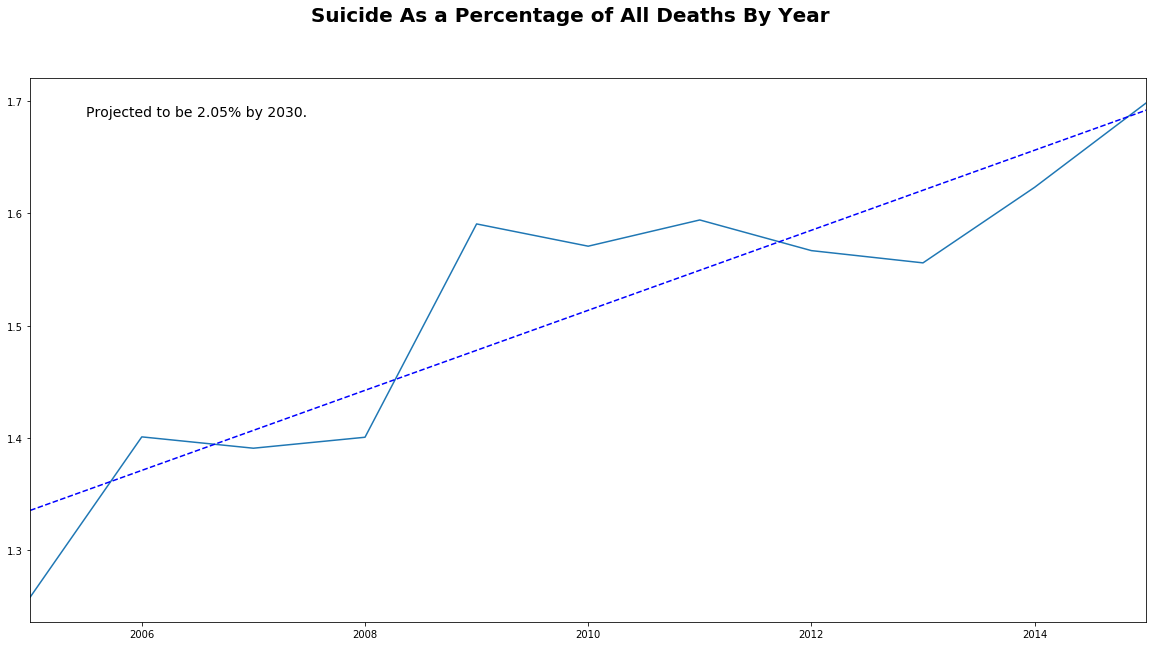

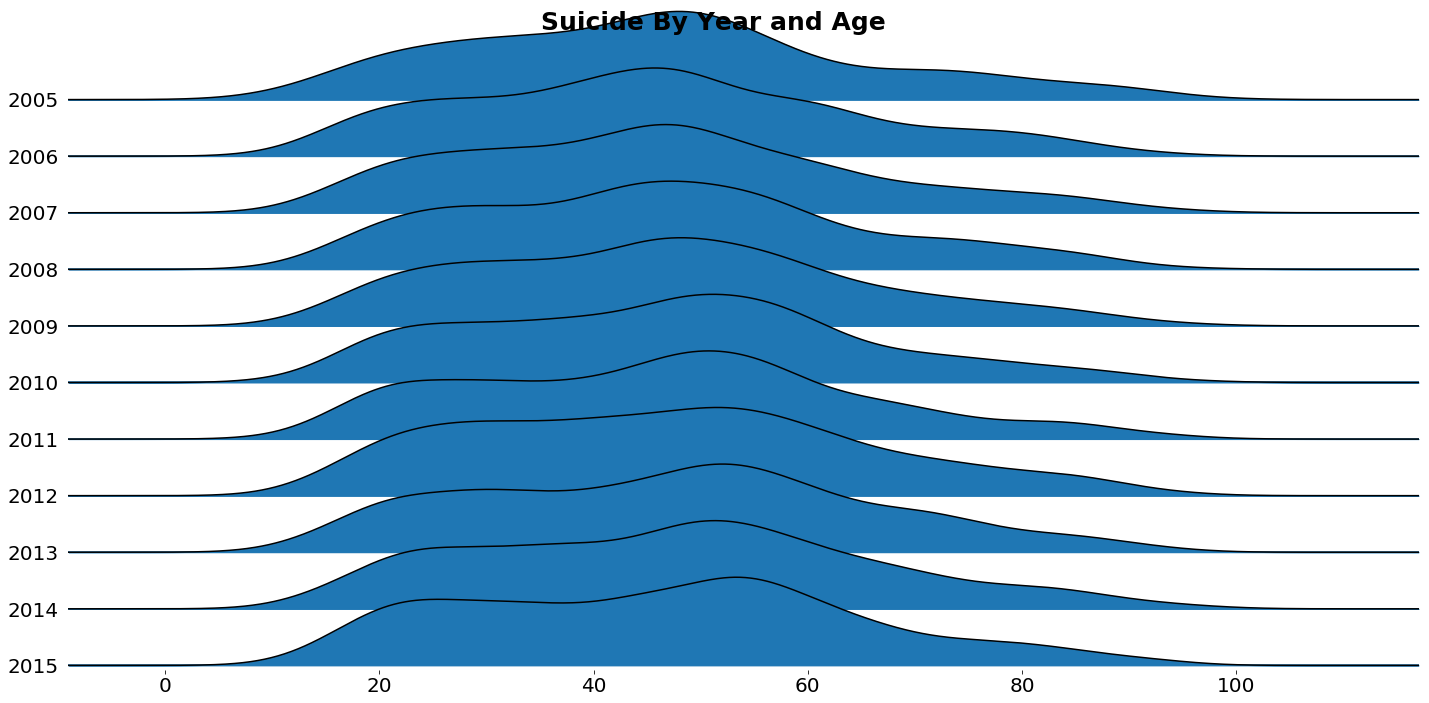

In [2]:
# Identify trend in suicide as a percentage of all deaths
YearGrp = deathdf.groupby(["current_data_year"])

SuicideCount = YearGrp["SuicideCnt"].sum()
OtherCount = YearGrp["OtherCnt"].sum()
AllDeaths = SuicideCount + OtherCount
SuiPercent = (SuicideCount / AllDeaths)*100

SuicideByYear = pd.DataFrame({"Suicide": SuicideCount,
                             "Other": OtherCount,
                              "Total Deaths": AllDeaths,
                             "Suicide Percent": SuiPercent})
SuicideByYear = SuicideByYear.reset_index()


year = SuicideByYear["current_data_year"]
suiper = SuicideByYear["Suicide Percent"]
sp_slope, sp_int, _, _, _ =stats.linregress(year, suiper)
sp_fit = sp_slope * year + sp_int
projyear = 2030
projected = round((sp_slope * 2025 + sp_int), 2)

textstr = "Projected to be " + str(projected) + "% by " + str(projyear) + "."

fig, ax1 = plt.subplots(figsize=(20, 10))
fig.suptitle("Suicide As a Percentage of All Deaths By Year", fontsize=20, fontweight="bold")
ax1.set_xlim(min(year), max(year))
ax1.plot(year, suiper)
ax1.plot(year, sp_fit, "b--")
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top')

yearAge = SuiOnly[["current_data_year", "detail_age"]]
yearAge["current_data_year"] = yearAge["current_data_year"].astype(str)
fig, ax4 = joypy.joyplot(yearAge, by="current_data_year", figsize=(20,10),
                        ylabelsize=20, xlabelsize=20, ylim='own')
fig.suptitle("Suicide By Year and Age", fontsize=25, fontweight="bold")

Text(0.5, 1.0, 'Percentage Suicides By Year and Education Level')

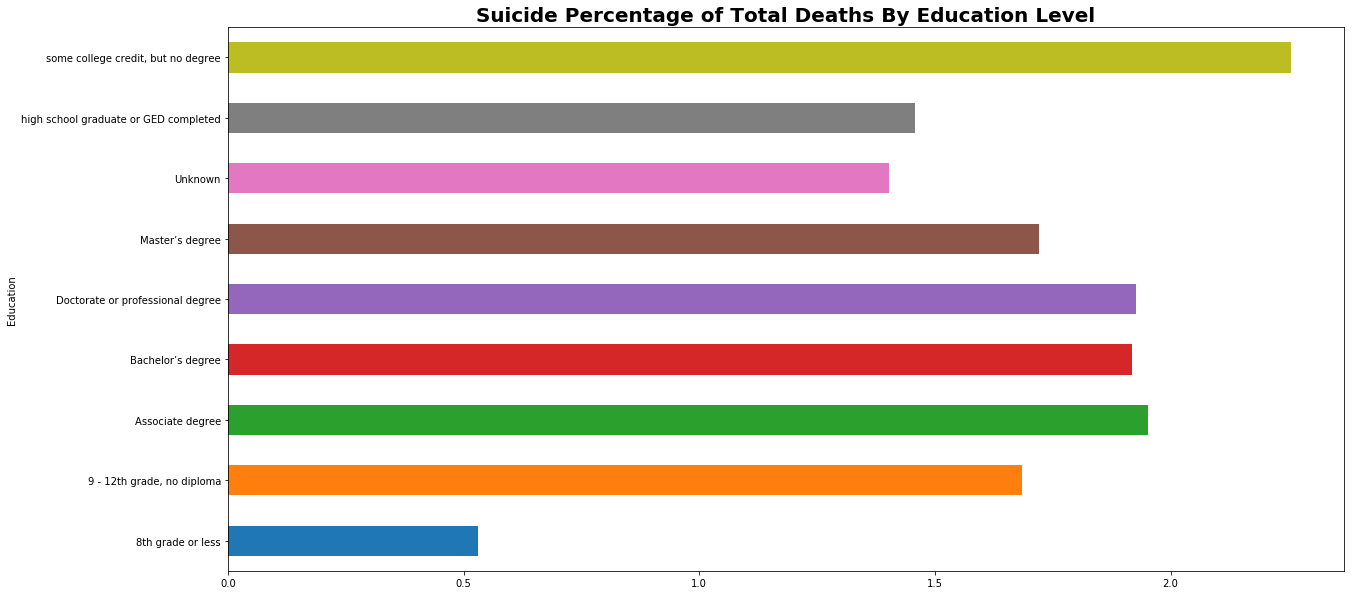

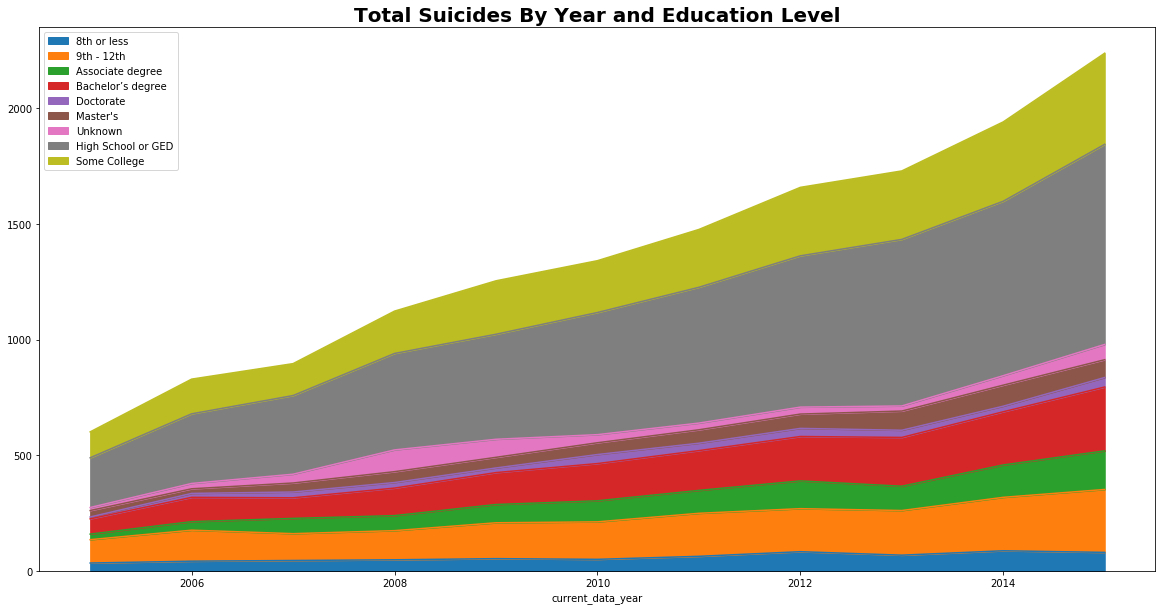

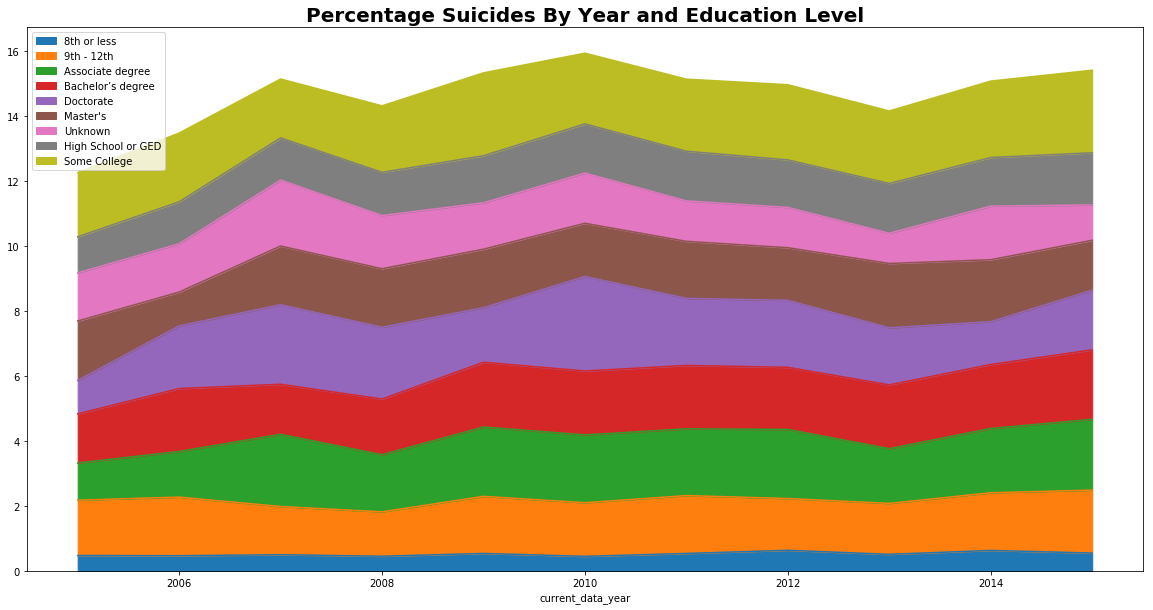

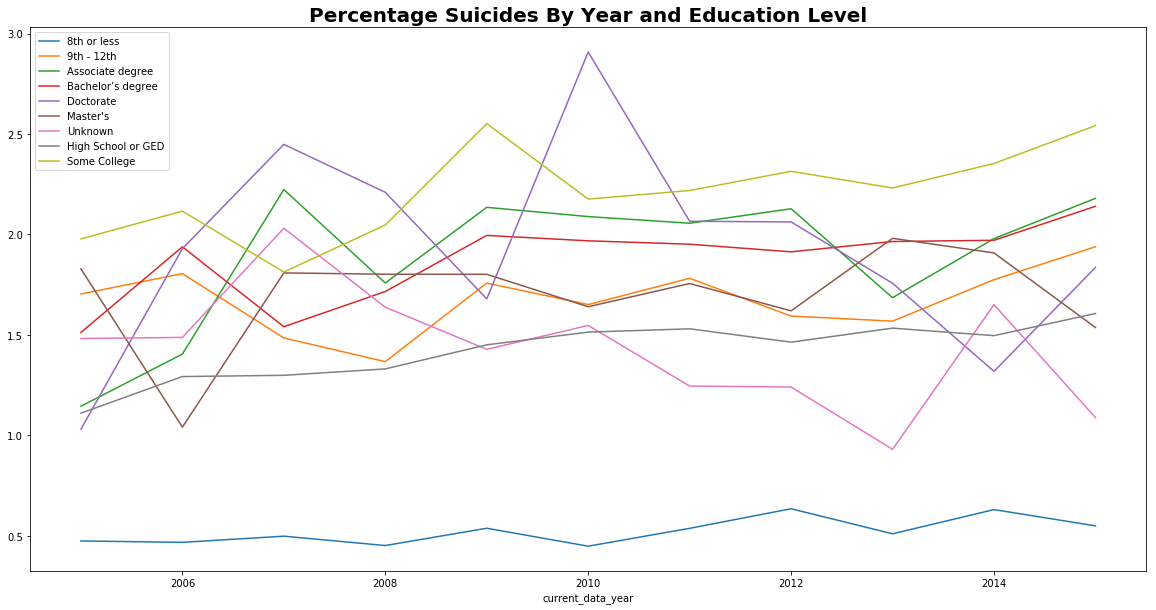

In [3]:
#create education groupby to identify suicide percentage by education group
EdGroup = deathdf.groupby(["Education"])

EdSuiCnt = EdGroup["SuicideCnt"].sum()
EdOtherCnt = EdGroup["OtherCnt"].sum()
EdAll = EdSuiCnt + EdOtherCnt
EdSuiPercent = (EdSuiCnt / EdAll)*100



SuicideByEducation = pd.DataFrame({"Suicide": EdSuiCnt,
                                  "Other": EdOtherCnt,
                                  "Suicide Percent":EdSuiPercent})
SuicideByEducation.plot(kind="barh", y="Suicide Percent", legend=False, figsize=(20, 10))
plt.title("Suicide Percentage of Total Deaths By Education Level", fontsize=20, fontweight="bold")





EdYearGroup = SuiOnly.groupby(["current_data_year"])

eighth = EdYearGroup["8th grade or less"].sum()
ninth = EdYearGroup["9 - 12th grade, no diploma"].sum()
assoc = EdYearGroup["Associate degree"].sum()
bach = EdYearGroup["Bachelor’s degree"].sum()
doc = EdYearGroup["Doctorate or professional degree"].sum()
mas = EdYearGroup["Master’s degree"].sum()
unkwn = EdYearGroup["Unknown"].sum()
hs = EdYearGroup["high school graduate or GED completed"].sum()
some = EdYearGroup["some college credit, but no degree"].sum()

EdYeardf = pd.DataFrame({"8th or less": eighth,
                        "9th - 12th": ninth,
                        "Associate degree": assoc,
                        "Bachelor’s degree":bach,
                        "Doctorate": doc,
                        "Master's":mas,
                        "Unknown": unkwn,
                        "High School or GED": hs,
                        "Some College":some})
EdYeardf.plot.area(figsize=(20, 10))
plt.title("Total Suicides By Year and Education Level", fontsize=20, fontweight="bold")



EdYearGroupOther = OtherOnly.groupby(["current_data_year"])

eighthother = EdYearGroupOther["8th grade or less"].sum()
ninthother = EdYearGroupOther["9 - 12th grade, no diploma"].sum()
assocother = EdYearGroupOther["Associate degree"].sum()
bachother = EdYearGroupOther["Bachelor’s degree"].sum()
docother = EdYearGroupOther["Doctorate or professional degree"].sum()
masother = EdYearGroupOther["Master’s degree"].sum()
unkwnother = EdYearGroupOther["Unknown"].sum()
hsother = EdYearGroupOther["high school graduate or GED completed"].sum()
someother = EdYearGroupOther["some college credit, but no degree"].sum()

EdYeardfOther = pd.DataFrame({"8th or less": eighthother,
                        "9th - 12th": ninthother,
                        "Associate degree": assocother,
                        "Bachelor’s degree":bachother,
                        "Doctorate": docother,
                        "Master's":masother,
                        "Unknown": unkwnother,
                        "High School or GED": hsother,
                        "Some College":someother})

EdYeardfAll = EdYeardf.merge(EdYeardfOther, left_index=True, right_index=True, suffixes=("","_O"))


EdYeardfAll["8thPer"] = (EdYeardfAll["8th or less"] / (EdYeardfAll["8th or less"] + EdYeardfAll["8th or less_O"]))*100
EdYeardfAll["9thPer"] = (EdYeardfAll["9th - 12th"] / (EdYeardfAll["9th - 12th"] + EdYeardfAll["9th - 12th_O"]))*100
EdYeardfAll["asscPer"] = (EdYeardfAll["Associate degree"] / (EdYeardfAll["Associate degree"] + EdYeardfAll["Associate degree_O"]))*100
EdYeardfAll["bachPer"] = (EdYeardfAll["Bachelor’s degree"] / (EdYeardfAll["Bachelor’s degree"] + EdYeardfAll["Bachelor’s degree_O"]))*100
EdYeardfAll["docPer"] = (EdYeardfAll["Doctorate"] / (EdYeardfAll["Doctorate"] + EdYeardfAll["Doctorate_O"]))*100
EdYeardfAll["masPer"] = (EdYeardfAll["Master's"] / (EdYeardfAll["Master's"] + EdYeardfAll["Master's_O"]))*100
EdYeardfAll["unkPer"] = (EdYeardfAll["Unknown"] / (EdYeardfAll["Unknown"] + EdYeardfAll["Unknown_O"]))*100
EdYeardfAll["hsPer"] = (EdYeardfAll["High School or GED"] / (EdYeardfAll["High School or GED"] + EdYeardfAll["High School or GED_O"]))*100
EdYeardfAll["somePer"] = (EdYeardfAll["Some College"] / (EdYeardfAll["Some College"] + EdYeardfAll["Some College_O"]))*100


EdYeardfAll = EdYeardfAll.drop(["8th or less", "8th or less_O",
                               "9th - 12th","9th - 12th_O",
                               "Associate degree", "Associate degree_O",
                               "Bachelor’s degree", "Bachelor’s degree_O",
                               "Doctorate", "Doctorate_O",
                               "Master's", "Master's_O",
                               "Unknown", "Unknown_O",
                               "High School or GED", "High School or GED_O",
                               "Some College", "Some College_O"], axis=1)

EdYeardfAll = EdYeardfAll.rename(columns={"8thPer": "8th or less",
                                         "9thPer": "9th - 12th",
                                         "asscPer": "Associate degree",
                                         "bachPer": "Bachelor’s degree",
                                         "docPer": "Doctorate",
                                         "masPer": "Master's",
                                         "unkPer": "Unknown",
                                         "hsPer": "High School or GED",
                                         "somePer": "Some College"})
EdYeardfAll.plot.area(figsize=(20, 10))
plt.title("Percentage Suicides By Year and Education Level", fontsize=20, fontweight="bold")
EdYeardfAll.plot.line(figsize=(20, 10))
plt.title("Percentage Suicides By Year and Education Level", fontsize=20, fontweight="bold")


Text(0.5, 0, '')

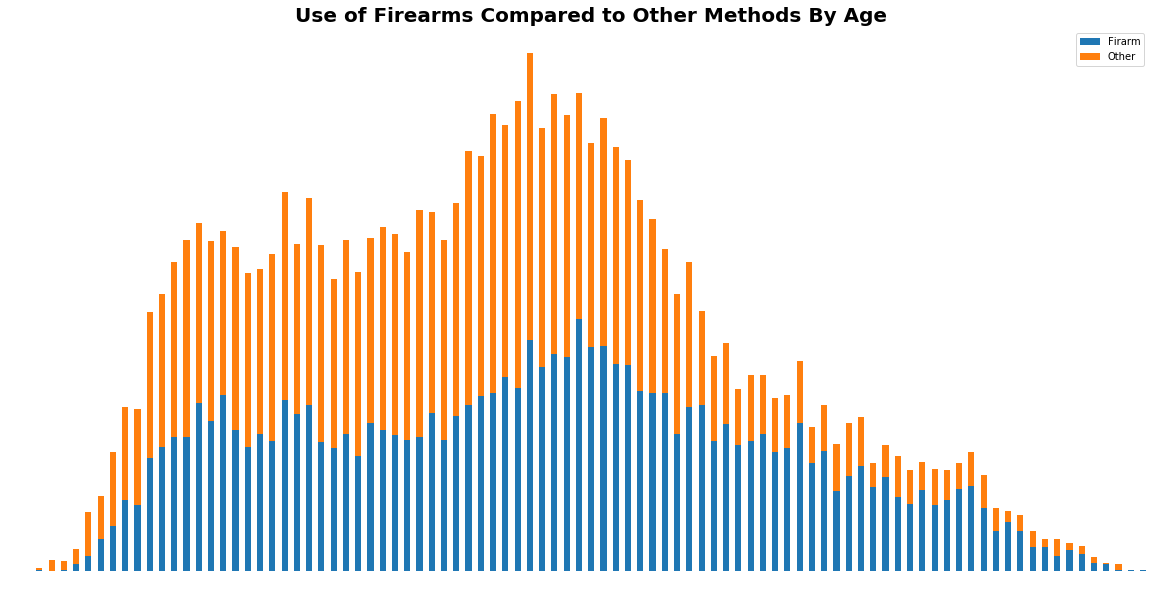

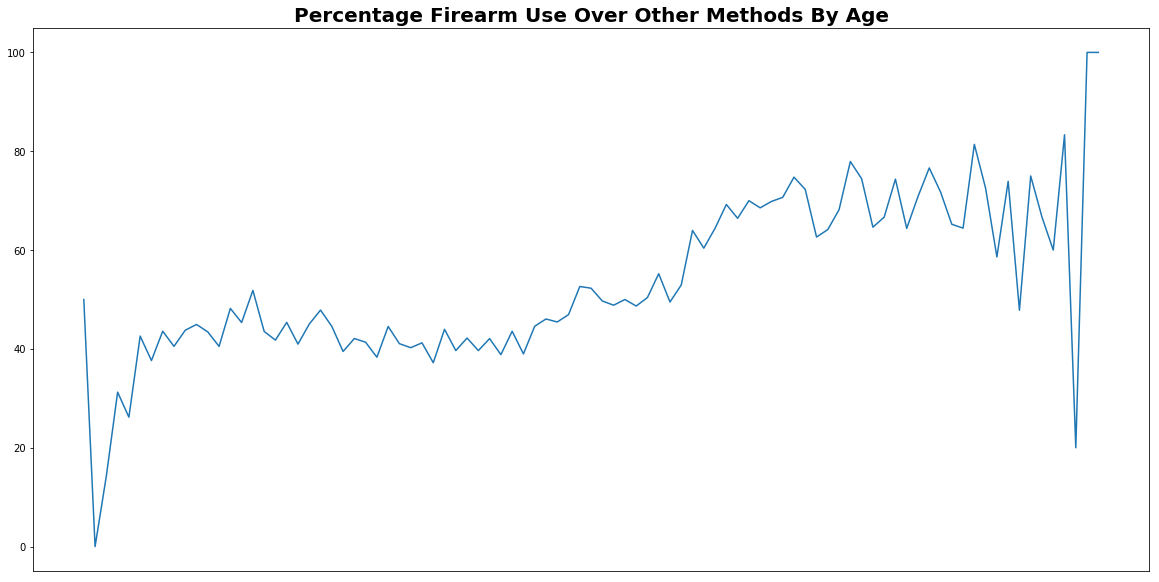

In [4]:
AgeGroup = SuiOnly.groupby(["detail_age"])

FireArmCnt = AgeGroup["FirearmCnt"].sum()
NonFireArmCnt = AgeGroup["NonFirearmCnt"].sum()
AllSuicides = FireArmCnt + NonFireArmCnt
FireArmPercent = (FireArmCnt/AllSuicides)*100

MthdByAge = pd.DataFrame({"Firarm":FireArmCnt,
                        "Other":NonFireArmCnt})

MthdByAge.plot(kind="bar", stacked=True, figsize=(20, 10))
plt.title("Use of Firearms Compared to Other Methods By Age", fontsize=20, fontweight="bold")
plt.axis("off")





FireArmPerdf = pd.DataFrame(FireArmPercent)
FireArmPerdf.plot(kind="line", legend=False, figsize=(20, 10))
plt.title("Percentage Firearm Use Over Other Methods By Age", fontsize=20, fontweight="bold")
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
plt.xlabel("")

Text(0.5, 1.0, 'Suicide as Percentage of Total Deaths By Gender and Marital Status')

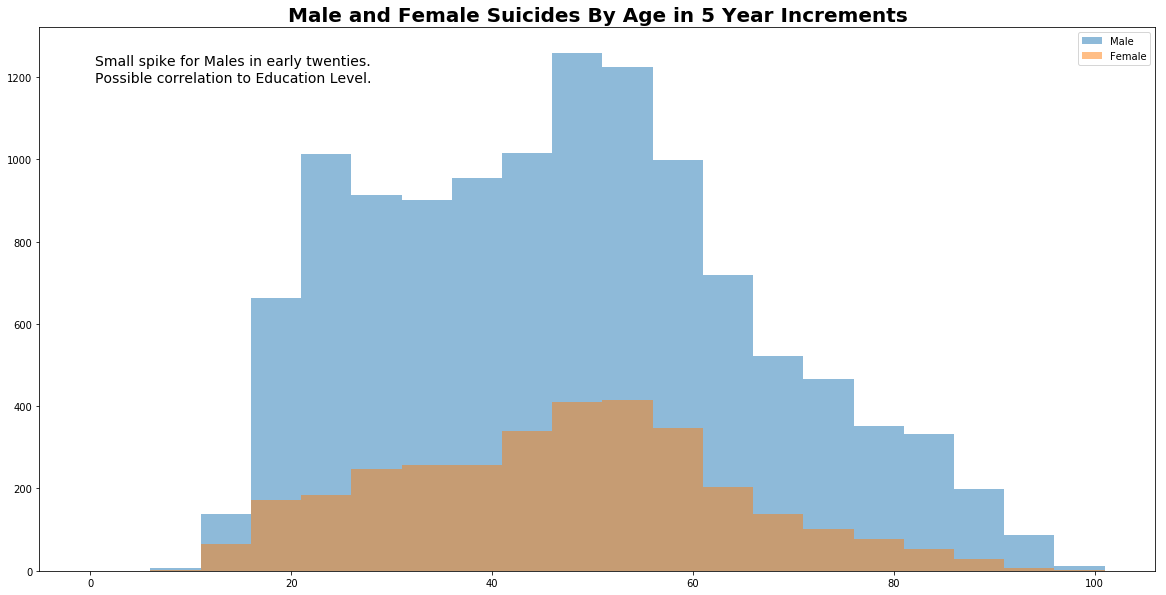

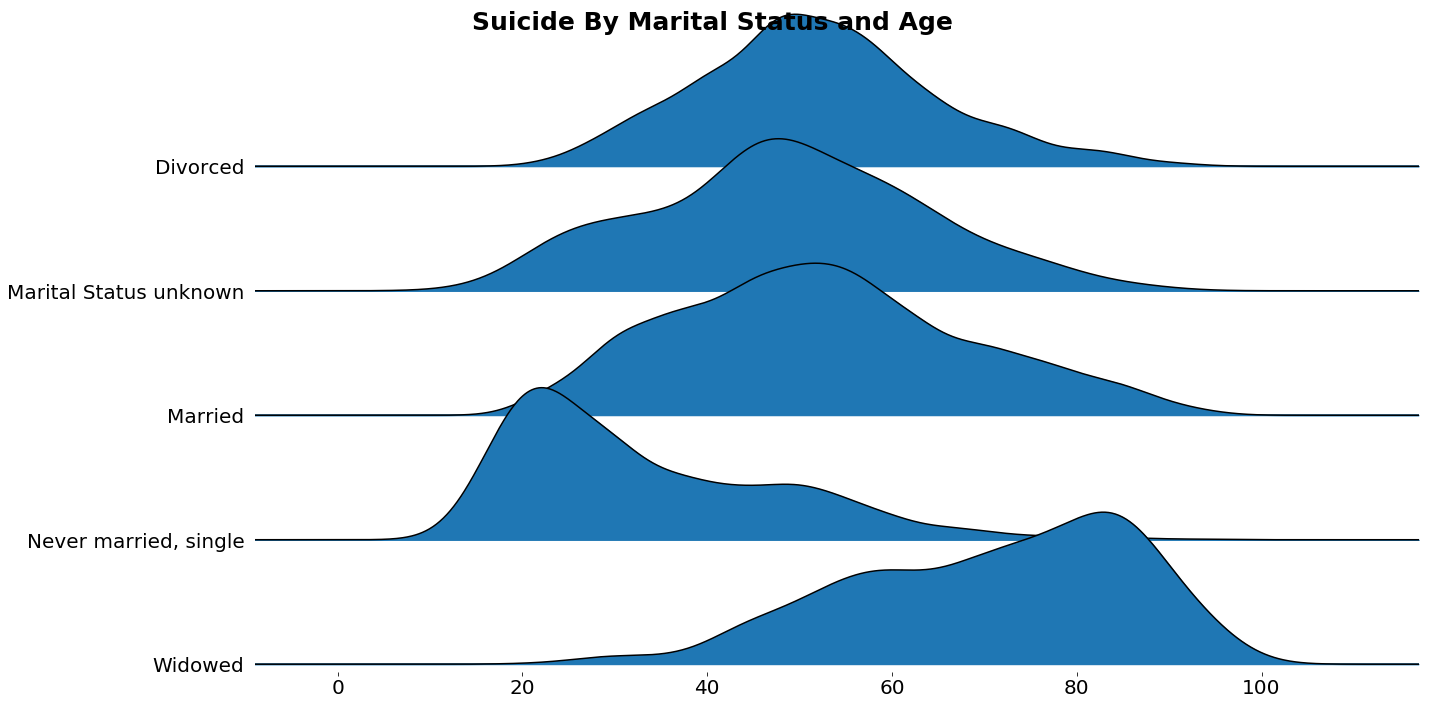

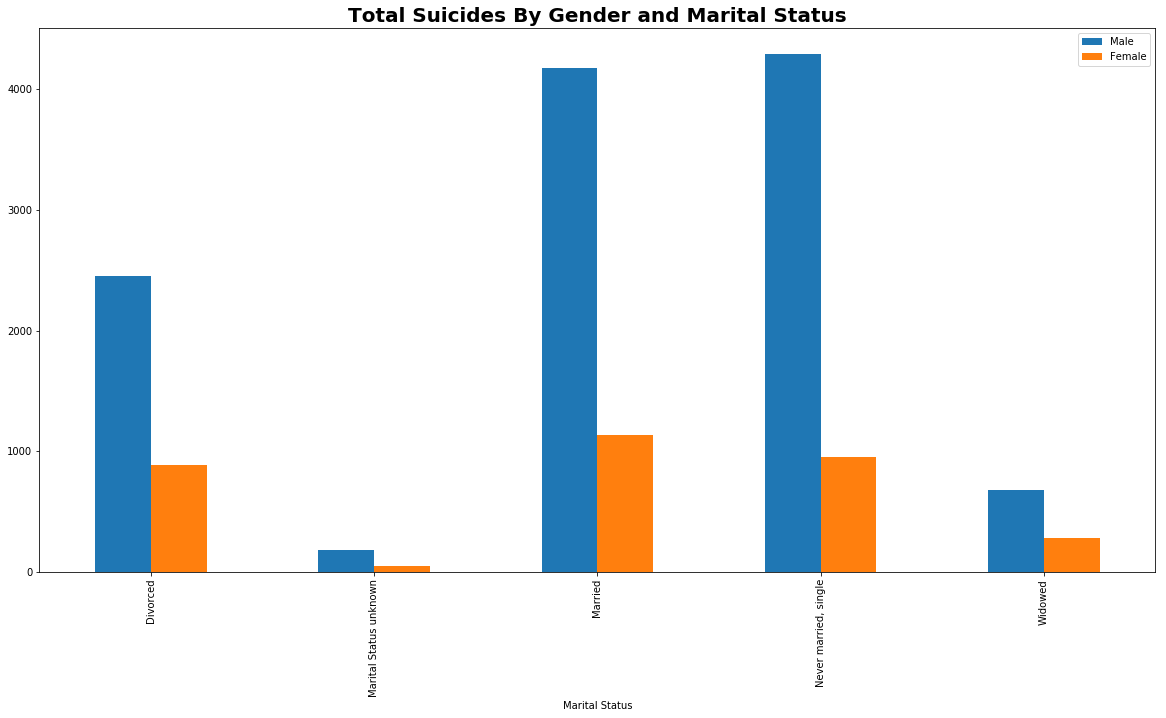

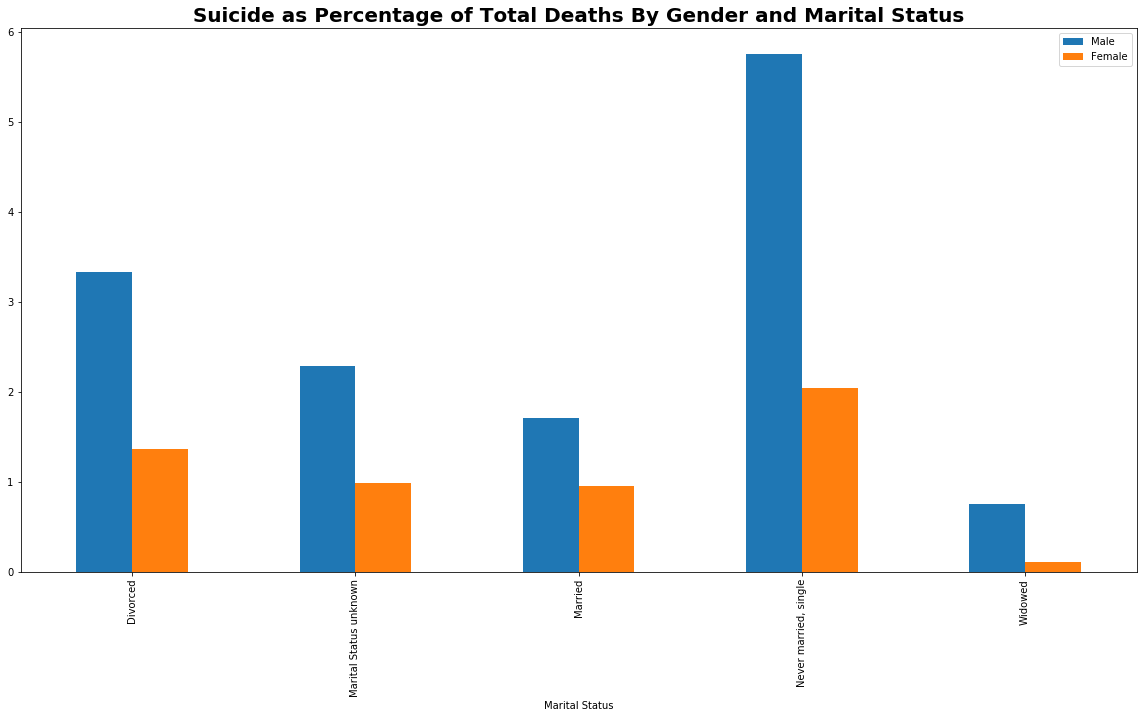

In [5]:
bins = [0, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101]

female = SuiOnly[SuiOnly["Female"] == 1]
femaleage = female["detail_age"]

male = SuiOnly[SuiOnly["Male"] == 1]
maleage = male["detail_age"]

fig, ax1 = plt.subplots(figsize=(20, 10))
plt.hist(maleage, bins=bins, alpha=0.5, label="Male")
plt.hist(femaleage, bins=bins, alpha=0.5, label="Female")
plt.title("Male and Female Suicides By Age in 5 Year Increments", fontsize=20, fontweight="bold")
plt.legend(loc="upper right")
textstr = "Small spike for Males in early twenties.  \nPossible correlation to Education Level."
plt.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top')


marAge = SuiOnly[["Marital Status", "detail_age"]]
fig, ax3 = joypy.joyplot(marAge, by="Marital Status", figsize=(20,10),
                        ylabelsize=20, xlabelsize=20, ylim='own')
fig.suptitle("Suicide By Marital Status and Age", fontsize=25, fontweight="bold")



marGroup = SuiOnly.groupby(["Marital Status"])

femalemar = marGroup["Female"].sum()
malemar = marGroup["Male"].sum()

marGroupdf = pd.DataFrame({"Male": malemar,
                           "Female": femalemar})


marGroupother = OtherOnly.groupby(["Marital Status"])
femalemarother = marGroupother["Female"].sum()
malemarother = marGroupother["Male"].sum()

marGroupPerc = pd.DataFrame({"Male_S": malemar,
                            "Female_S": femalemar,
                            "Male_O": malemarother,
                            "Female_O": femalemarother})
marGroupPerc["Male"] = (marGroupPerc["Male_S"] / (marGroupPerc["Male_S"] + marGroupPerc["Male_O"]))*100
marGroupPerc["Female"] = (marGroupPerc["Female_S"] / (marGroupPerc["Female_S"] + marGroupPerc["Female_O"]))*100

marGroupPerc = marGroupPerc[["Male", "Female"]]


marGroupdf.plot(kind="bar", figsize=(20, 10))
plt.title("Total Suicides By Gender and Marital Status", fontsize=20, fontweight="bold")

marGroupPerc.plot(kind="bar", figsize=(20, 10))
plt.title("Suicide as Percentage of Total Deaths By Gender and Marital Status", fontsize=20, fontweight="bold")





In [6]:
SuiOnly.dtypes

Unnamed: 0                                 int64
113_cause_recode                           int64
130_infant_cause_recode                  float64
358_cause_recode                         float64
39_cause_recode                          float64
Unnamed: 0.1                               int64
Unnamed: 0.1.1                           float64
activity_code                            float64
age_recode_12                            float64
age_recode_27                            float64
age_recode_52                            float64
autopsy                                   object
current_data_year                          int64
day_of_week_of_death                       int64
detail_age                                 int64
detail_age_type                          float64
education_2003_revision                  float64
hispanic_origin                          float64
hispanic_originrace_recode                 int64
icd_code_10th_revision                    object
infant_age_recode_22

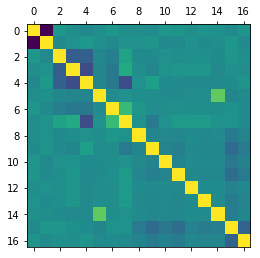

<Figure size 1440x720 with 0 Axes>

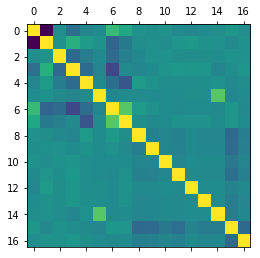

<Figure size 1440x720 with 0 Axes>

In [7]:
corr1 = SuiOnly[["Female", "Male", "D", "M", "S", "U", "W", "Method", "detail_age", "8th grade or less",
                "9 - 12th grade, no diploma", "Associate degree", "Bachelor’s degree", "Doctorate or professional degree",
                "Master’s degree", "Unknown", "high school graduate or GED completed", "some college credit, but no degree"]]

corr2 = deathdf[["Female", "Male", "D", "M", "S", "U", "W", "Method", "detail_age", "8th grade or less",
                "9 - 12th grade, no diploma", "Associate degree", "Bachelor’s degree", "Doctorate or professional degree",
                "Master’s degree", "Unknown", "high school graduate or GED completed", "some college credit, but no degree"]]


from matplotlib.pyplot import figure

plt.matshow(corr1.corr())
figure(figsize=(20,10))
plt.show()
                
                
plt.matshow(corr2.corr())
figure(figsize=(20,10))
plt.show()
